In [2]:
import pandas as pd, numpy as np
from __future__ import division
from collections import defaultdict

In [3]:
# read in data 

fuf = pd.read_csv('../data/combined_tree_data_with_header_with_derived_neighborhood.csv').fillna('')
fuf = fuf.rename(columns={'derived_neighborhood':'neighborhood'})

/usr/local/lib/python2.7/site-packages/ipython-4.0.0-py2.7.egg/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Diversity 

In [4]:
# when the condition of the tree is bad, the species is reported in a weird way. remove those.

bad_condition = ['dead', 'vacancy', 'stump', 'unsuitable site', 'stump removal', 'open']

fuf.ix[fuf.scientific_species_name<>'', 'genus'] = fuf[fuf.scientific_species_name<>'' \
                                            ].scientific_species_name.apply(lambda x: x.split()[0])

diversity = fuf[~fuf.condition.isin(bad_condition)].groupby(['neighborhood', 'genus']\
                                                    ).size().reset_index().rename(columns={0:'cnt'})

cnts = fuf[~fuf.condition.isin(bad_condition)].groupby(['neighborhood']\
                                                      ).size().reset_index().rename(columns={0:'cnt'})

diversity = pd.merge(diversity,cnts,on='neighborhood')
diversity['pct'] = diversity.apply(lambda x: x.cnt_x/x.cnt_y, axis=1)
diversity['not_diverse'] = diversity.pct.apply(lambda x: 1 if x>=.2 else 0)
diversity = diversity.groupby('neighborhood').not_diverse.sum().reset_index()

# Hardscape

In [5]:
fuf['hardscape_metric'] = fuf['hardscape_damage'].apply(lambda x: 0 if x in ['None','No', 'NA'] else 1)

hardscape = fuf.groupby('neighborhood')['hardscape_metric'].mean().reset_index()

# Vacant Lot

In [6]:
fuf['vacant_lot_metric'] = fuf['condition'].apply(lambda x: 0 if x != 'Vacancy' else 1)
vacant = fuf.groupby('neighborhood')['vacant_lot_metric'].mean().reset_index()

# Condition Score

In [7]:
#assuming very = very good
condition_score = defaultdict(lambda: '' )
csd = {
    'dead':0,
    'critical':1,
    'poor':2,
    'fair':3,
    'good':4,
    'very':5,
    'very good':5,
    'excellent':6
}
for c in csd:
    condition_score[c] = csd[c]

fuf['condition_score'] = fuf.condition.apply(lambda x: condition_score[x.lower().strip()])
condition = fuf[fuf.condition_score<>'']
condition['condition_score'] = condition.condition_score.astype(int)
condition = condition.groupby('neighborhood')['condition_score'].mean().reset_index()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Modeling Setup

In [8]:
fuf_scored = fuf[fuf['condition_score']!=''][['tree_id','neighborhood', 'genus', 'condition_score']]

In [9]:
n_neighborhoods = fuf_scored.neighborhood.unique().shape[0]
n_genuses = fuf_scored.genus.unique().shape[0]
print 'Number of neighborhoods = ' + str(n_neighborhoods) + ' | Number of genuses = ' + str(n_genuses)  

Number of neighborhoods = 104 | Number of genuses = 242


## Create unique ids for neighborhoods and genuses

In [11]:
fuf_scored['neighborhood'] = fuf_scored['neighborhood'].astype('category').cat.codes
fuf_scored['genus'] = fuf_scored['genus'].astype('category').cat.codes

In [23]:
fuf_scored = fuf_scored[['neighborhood', 'genus', 'condition_score']]
fuf_scored.head()

,neighborhood,genus,condition_score
0,46,225,4
2,46,180,3
3,46,150,3
4,46,150,4
5,41,172,3


In [46]:
fuf_scored['condition_score'].value_counts()

3    47743
2    25219
4    23695
5     1446
0     1110
1      205
6      175
Name: condition_score, dtype: int64

- For now, will use condition score to recommend genuses for neighborhoods (explicit feedback model using condition score)

In [17]:
from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(fuf_scored[['neighborhood', 'genus']], test_size=0.25)

In [24]:
matrix = np.zeros((n_neighborhoods, n_genuses))
for row in fuf_scored.itertuples():
    matrix[row[1]-1, row[2]-1] = row[3]
matrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [54]:
matrix[0:3]

array([[ 0.,  0.,  0.,  0.,  3.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,
         0.,  3.,  0.,  0.,  0.,  3.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,
         0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  3.,  0.,  0.,  0.,  4.,
         0.,  0.,  4.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,
         0.,  3.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  2.,  0.,
         0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         3.,  0.,  3.,  3.,  0.,  4.,  0.,  3.,  0.

In [26]:
sparsity = float(len(matrix.nonzero()[0]))
sparsity /= (matrix.shape[0] * matrix.shape[1])
sparsity *= 100
print 'Sparsity: {:4.2f}%'.format(sparsity)

Sparsity: 18.79%


In this dataset, every user has rated at least 20 movies which results in a reasonable sparsity of 6.3%. This means that 6.3% of the user-item ratings have a value. Note that, although we filled in missing ratings as 0, we should not assume these values to truly be zero. More appropriately, they are just empty entries. We will split our data into training and test sets by removing 10 ratings per user from the training set and placing them in the test set.

In [30]:
def train_test_split(matrix):
    test = np.zeros(matrix.shape)
    train = matrix.copy()
    for user in xrange(matrix.shape[0]):
        test_ratings = np.random.choice(matrix[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = matrix[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [32]:
train, test = train_test_split(matrix)

In [33]:
def fast_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [34]:
%timeit fast_similarity(train, kind='user')

The slowest run took 41.79 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 167 µs per loop


In [35]:
user_similarity = fast_similarity(train, kind='user')
item_similarity = fast_similarity(train, kind='item')
print item_similarity[:4, :4]

[[  1.00000000e+00   7.90569415e-06   1.05409255e-05   4.38529010e-06]
 [  7.90569415e-06   1.00000000e+00   8.33333333e-11   5.54700196e-01]
 [  1.05409255e-05   8.33333333e-11   1.00000000e+00   4.62250163e-11]
 [  4.38529010e-06   5.54700196e-01   4.62250163e-11   1.00000000e+00]]


In [36]:
def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [37]:
%timeit predict_fast_simple(train, user_similarity, kind='user')

1000 loops, best of 3: 282 µs per loop


In [38]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [39]:
item_prediction = predict_fast_simple(train, item_similarity, kind='item')
user_prediction = predict_fast_simple(train, user_similarity, kind='user')

print 'User-based CF MSE: ' + str(get_mse(user_prediction, test))
print 'Item-based CF MSE: ' + str(get_mse(item_prediction, test))

User-based CF MSE: 3.60681917086
Item-based CF MSE: 5.53241252697


In [40]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in xrange(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in xrange(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in xrange(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in xrange(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [41]:
pred = predict_topk(train, user_similarity, kind='user', k=40)
print 'Top-k User-based CF MSE: ' + str(get_mse(pred, test))

pred = predict_topk(train, item_similarity, kind='item', k=40)
print 'Top-k Item-based CF MSE: ' + str(get_mse(pred, test))


Top-k User-based CF MSE: 3.26394565037
Top-k Item-based CF MSE: 3.73013482554


In [48]:
(pred,test)

(array([[ 0.        ,  0.        ,  0.10199197, ...,  0.        ,
          0.27220323,  0.17439026],
        [ 0.        ,  0.        ,  0.03504058, ...,  0.        ,
          0.13415442,  0.03740429],
        [ 0.        ,  0.        ,  0.24494453, ...,  0.10829116,
          0.51138048,  0.44442624],
        ..., 
        [ 0.        ,  0.        ,  0.08804395, ...,  0.        ,
          0.14356199,  0.10711839],
        [ 0.        ,  0.        ,  0.34176215, ...,  0.05185545,
          0.64290343,  0.51473021],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.35658483,  0.22751672]]),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]))

In [49]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

for k in k_array:
    user_pred = predict_topk(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]  

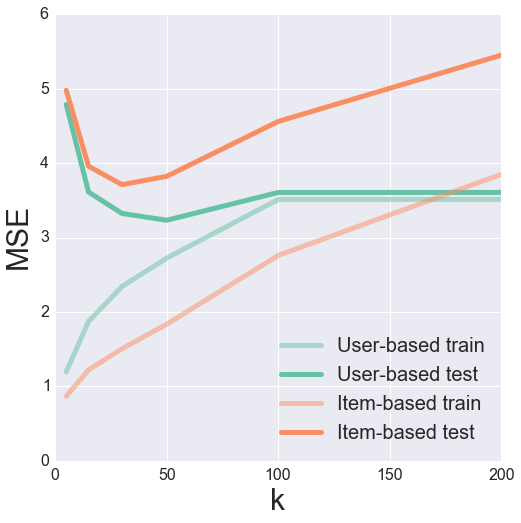

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

## APPENDIX

In [10]:
#neighborhood areas courtesy of Spencer (units unknown)

neighborhood_area = """Seacliff, 584559
Lake Street, 486588
Presidio National Park, 7785081
Presidio Terrace, 416901
Inner Richmond, 2873215
Sutro Heights, 713105
Lincoln Park / Ft. Miley, 1575630
Outer Richmond, 3745203
Golden Gate Park, 5535110
Presidio Heights, 728466
Laurel Heights / Jordan Park, 739172
Lone Mountain, 1030917
Anza Vista, 381957
Cow Hollow, 500591
Union Street, 616335
Marina, 1860177
Telegraph Hill, 321562
Downtown / Union Square, 456142
Tenderloin, 677681
Civic Center, 667217
Hayes Valley, 370172
Alamo Square, 313007
Panhandle, 722099
Haight Ashbury, 427566
Lower Haight, 561154
Mint Hill, 193861
Duboce Triangle, 543148
Cole Valley, 234774
Rincon Hill, 478124
South Beach, 879238
South of Market, 3926306
Showplace Square, 804205
Mission Bay, 2032371
Yerba Buena Island, 813945
Treasure Island, 2106231
Mission Dolores, 1075383
Castro, 309558
Outer Sunset, 8933628
Parkside, 3860649
Stonestown, 882009
Parkmerced, 1596457
Lakeshore, 7973826
Golden Gate Heights, 2117466
Forest Hill, 650261
West Portal, 917441
Clarendon Heights, 689473
Midtown Terrace, 696602
Laguna Honda, 1086186
Upper Market, 685945
Dolores Heights, 1181255
Mission, 3947711
Potrero Hill, 2971407
Dogpatch, 537768
Central Waterfront, 3297821
Diamond Heights, 804222
Fairmount, 747602
Peralta Heights, 383378
Holly Park, 568742
Merced Manor, 732556
Balboa Terrace, 351418
Ingleside, 1199810
Merced Heights, 960282
Outer Mission, 992289
Ingleside Terraces, 779681
Mt. Davidson Manor, 289695
Monterey Heights, 333667
Westwood Highlands, 185864
Westwood Park, 718318
Miraloma Park, 1223401
Crocker Amazon, 1834895
McLaren Park, 1730345
Sunnydale, 475674
Visitacion Valley, 1579119
India Basin, 1028498
Hunters Point, 3757633
Candlestick Point SRA, 2009785
Northern Waterfront, 728122
Cayuga, 938958
Oceanview, 1280145
Apparel City, 467624
Bernal Heights, 2186907
Noe Valley, 1839016
Produce Market, 1086990
Bayview, 3265434
Silver Terrace, 1304052
Bret Harte, 1069454
Little Hollywood, 560864
Portola, 2385740
University Mound, 726962
St. Marys Park, 519616
Mission Terrace, 1614676
Excelsior, 2120210
Sunnyside, 1460251
Glen Park, 1136228
Aquatic Park / Ft. Mason, 536736
Fishermans Wharf, 839951
Cathedral Hill, 622632
Japantown, 370871
Pacific Heights, 2268224
Lower Pacific Heights, 769251
Western Addition, 1201797
Chinatown, 403662
Nob Hill, 810649
Lower Nob Hill, 546137
Polk Gulch, 382432
North Beach, 737700
Russian Hill, 1200788
Financial District, 1049942
Inner Sunset, 1425791
Parnassus Heights, 916689
Forest Knolls, 569284
Buena Vista, 861252
Corona Heights, 360528
Ashbury Heights, 435637
Eureka Valley, 961785
St. Francis Wood, 548679
Sherwood Forest, 684025"""

area_df = pd.DataFrame([x.split(',') for x in neighborhood_area.split('\n')], columns=['neighborhood', 'area'])
area_df['area'] = area_df.area.astype(int)
area_df['miles'] = area_df.area/(5280*5280)

# only count trees that don't have a bad condition
density = fuf[~fuf.condition.isin(bad_condition)].groupby('neighborhood').size().reset_index().rename(columns={0:'tree_cnt'})
density = pd.merge(density, area_df, on='neighborhood')
density['density'] = density.apply(lambda x: x.tree_cnt/x.miles, axis=1)

In [17]:
inv_csd = {v: k for k, v in csd.iteritems()}
condition['condition_lable'] = condition.condition_score.apply(lambda x: inv_csd[int(round(x))] if x else x)

In [18]:
m = pd.merge(diversity, density, on='neighborhood', how='left')
m = pd.merge(m, condition, on='neighborhood', how='left')
m = pd.merge(m, vacant, on='neighborhood', how='left')
m = pd.merge(m, hardscape, on='neighborhood', how='left')

m = m.rename(columns ={'neighborhood':'Neighborhood',
              'not_diverse':'Diversity', 
              'condition_score':'Condition', 
              'vacant_lot_metric':'Vacancies', 
              'hardscape_metric':'Sidewalk Damage',
              'density':'Density',
              'condition_lable':'Condition Label',
              'tree_cnt':'Tree Count'})

m = m[['Neighborhood', 'Density', 'Diversity', 'Condition', 'Condition Label', 'Vacancies', 'Sidewalk Damage', 'Tree Count']]
m = m[~m.Density.isnull()]

In [19]:
m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103 entries, 0 to 103
Data columns (total 8 columns):
Neighborhood       103 non-null object
Density            103 non-null float64
Diversity          103 non-null int64
Condition          103 non-null float64
Condition Label    103 non-null object
Vacancies          103 non-null float64
Sidewalk Damage    103 non-null float64
Tree Count         103 non-null float64
dtypes: float64(5), int64(1), object(2)
memory usage: 7.2+ KB


In [23]:
# Scale metrics from 0-10 for display purposes
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scale_df = m[['Density', 'Diversity', 'Condition', 'Vacancies', 'Sidewalk Damage']]
scale_df = pd.DataFrame(scaler.fit_transform(scale_df), columns=scale_df.columns)*10
scale_df = scale_df.round()

scale_df['Neighborhood'] = m.Neighborhood

In [24]:
scale_df

,Density,Diversity,Condition,Vacancies,Sidewalk Damage,Neighborhood
0,5.0,0.0,6.0,0.0,3.0,Alamo Square
1,4.0,3.0,6.0,0.0,2.0,Anza Vista
2,1.0,3.0,1.0,0.0,4.0,Aquatic Park / Ft. Mason
3,6.0,0.0,4.0,1.0,4.0,Ashbury Heights
4,3.0,3.0,4.0,2.0,3.0,Balboa Terrace
5,1.0,3.0,7.0,0.0,3.0,Bayview
6,5.0,0.0,2.0,1.0,4.0,Bernal Heights
7,1.0,3.0,8.0,0.0,2.0,Bret Harte
8,4.0,0.0,4.0,1.0,4.0,Buena Vista
9,7.0,0.0,1.0,0.0,4.0,Castro
